## Unsupervised Learning Approaches

### Nonparametric UMAP

Let's make some UMAP embeddings. Our goal in this analysis is to see if we can use unsupervised learning to 
understand the data better and potentially build a classifier but applying some simple clustering techniques.

In [2]:
from data.get_data import load_mnist
import umap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import itertools

In [3]:
# reading in data
X_train, y_train = load_mnist('data/f_mnist_data', kind='train')
X_test, y_test = load_mnist('data/f_mnist_data', kind='t10k')

Scaled_X_train, Scaled_X_test = X_train/255.0, X_test/255.0

In [18]:
# let's start with a simple 2-D embedding
embedding_model = umap.UMAP(n_neighbors=5, min_dist=.001, n_components=2).fit(Scaled_X_train)
embedding = embedding_model.transform(Scaled_X_test)

In [8]:
target = y_test
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

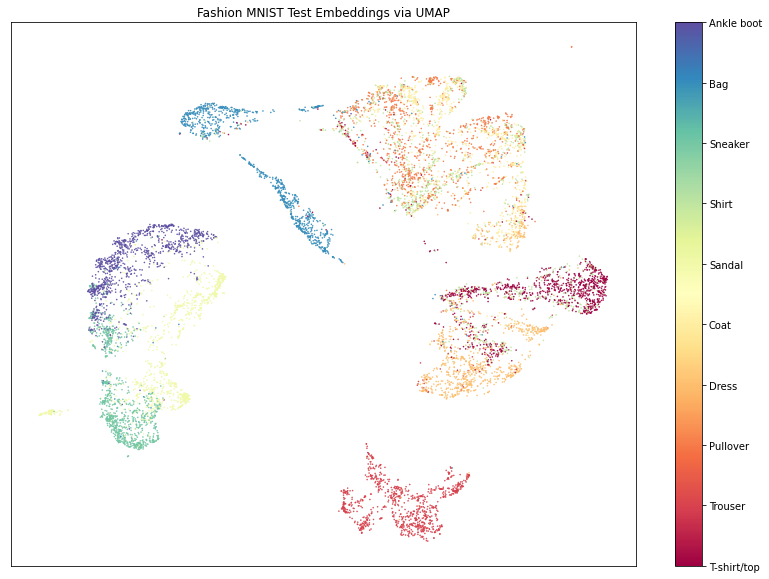

In [22]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Test Embeddings via UMAP');

There's clear separation from some classes like bags and trousers. Ankle boot, sneaker, and sandle are close but still fairly separble. On the other hand, shirt, t-shirt, pullover, and coat have very heterogeneous clustering. It's hard to distinguish between those items.

maybe adding dimension will help? Let's try 4 and map the various 2-D projections of the 4-D space.

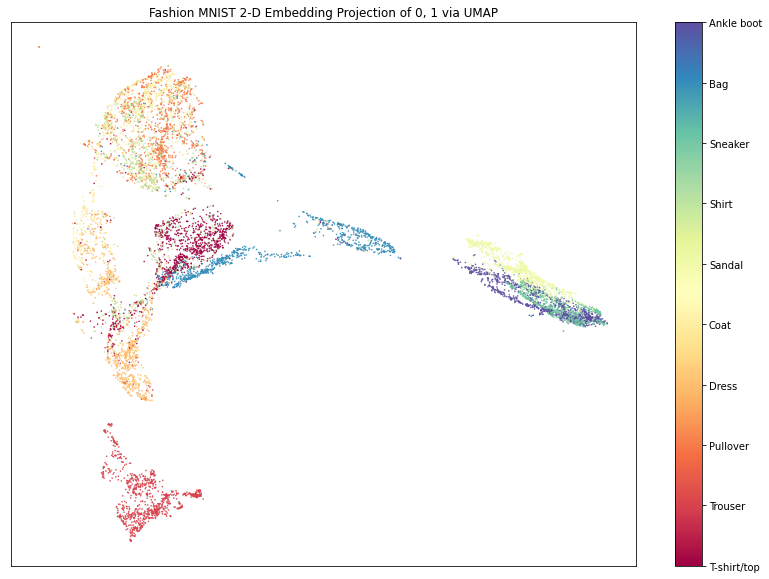

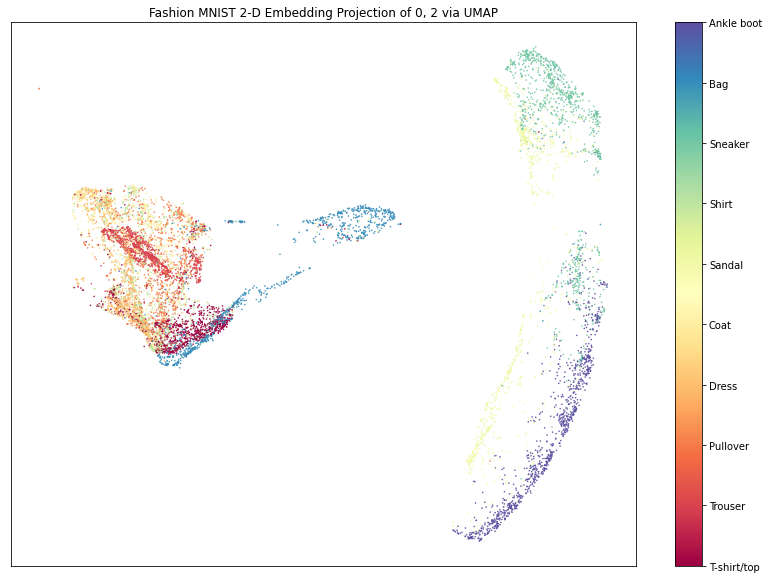

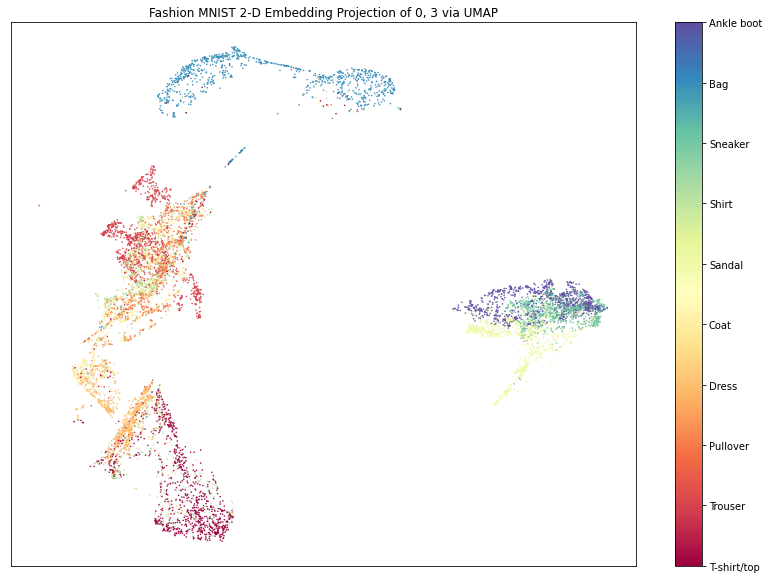

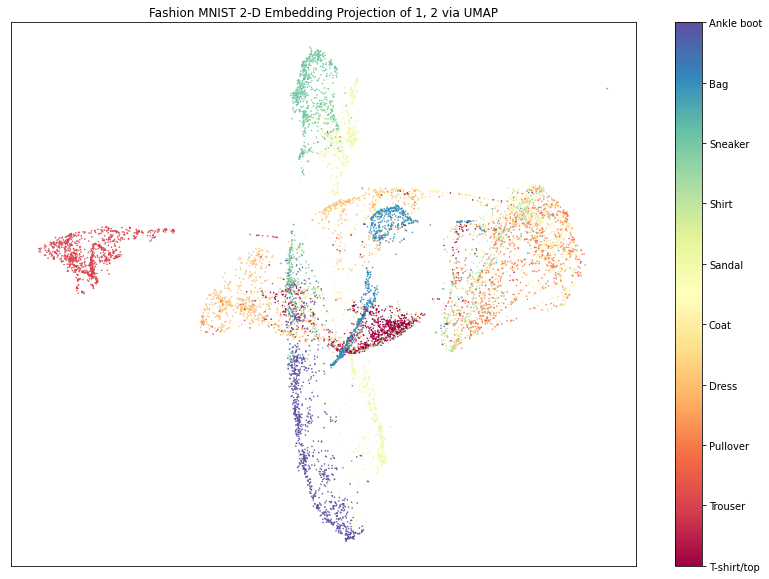

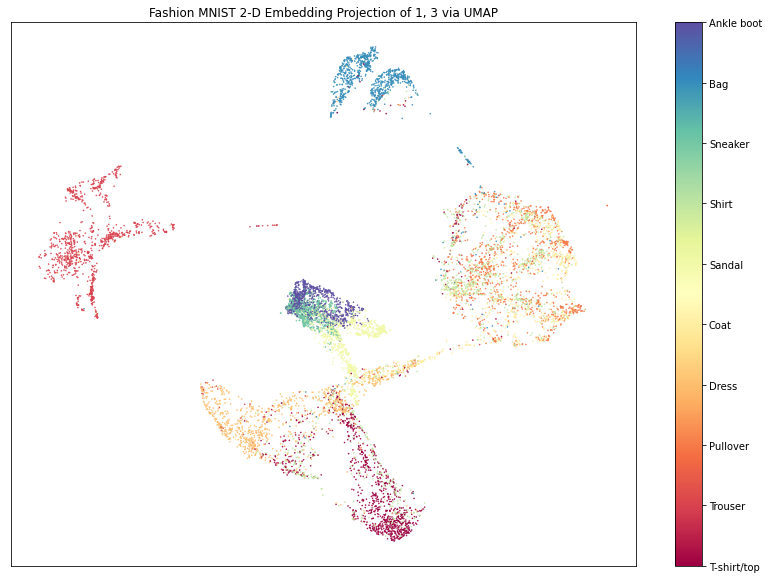

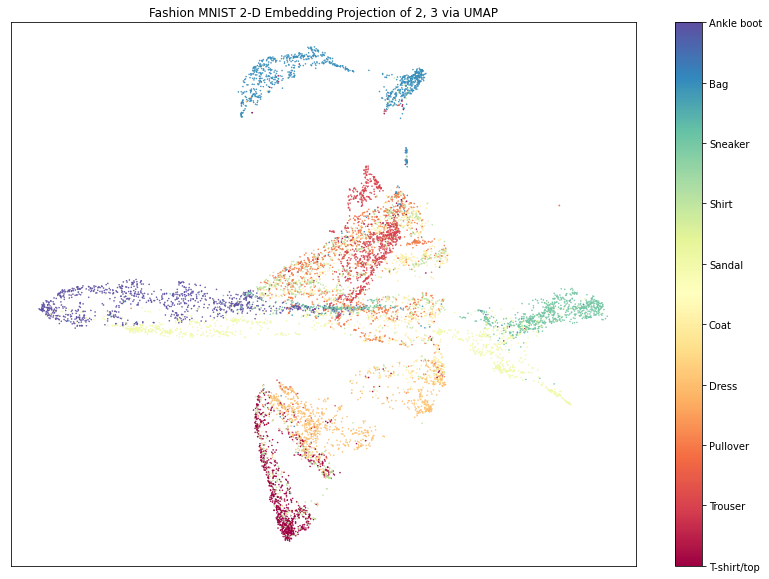

In [25]:
embedding_model = umap.UMAP(n_neighbors=5, min_dist=.001, n_components=4).fit(Scaled_X_train)
embedding = embedding_model.transform(Scaled_X_test)

basis_cols = list(itertools.combinations(range(4), 2))

for basis_pairs in basis_cols:
    temp_embedding = embedding[:,basis_pairs]
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*temp_embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    plt.title(
        # title names contain the components used in the plot
        f'Fashion MNIST 2-D Embedding Projection of {", ".join([str(basis) for basis in basis_pairs])} via UMAP'
    );

Doesn't look like we get any better separation in the higher dimension. This visualization is certainly lossy,
so we may be missing something. But the clusters from earlier are still so muddled I don't think it's likely the 
higher dimension helped with separating the classes.

In [26]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

components = 4

db = DBSCAN(eps=0.2, min_samples=components+1).fit(embedding)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# important test metrics
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, labels))

Estimated number of clusters: 128
Estimated number of noise points: 902
Homogeneity: 0.641


The homogeinity of clusters is solid, but not great. Unlikely we'll get great class separation in the clusters.
Let's see what distribution of labels we have in some of the clusters. 

In [28]:
# distribution of classes in first cluster
np.unique(y_test[labels == 1], return_counts=True)

(array([0, 2, 4, 6, 8], dtype=uint8), array([  1,  78, 103,  64,   2]))

multiple viable candidates here: could be a pullover, coat, or shirt! 

In [29]:
# distribution of classes in second cluster
np.unique(y_test[labels == 2], return_counts=True)

(array([1], dtype=uint8), array([161]))

Clear homogeneity in this cluster for the trousers. This matches our earlier findings. 

In [30]:
# distribution of classes in third cluster
np.unique(y_test[labels == 3], return_counts=True)

(array([1, 3, 4], dtype=uint8), array([348,   4,   1]))

Again, clear separation of the trousers embeddings. Some incorrect classifications but majority belong to trouser class.

In [49]:
# let's pick a random cluster!
# distribution of classes in 41st cluster
np.unique(y_test[labels == 41], return_counts=True)

(array([2, 4, 6], dtype=uint8), array([23, 19,  3]))

Here we again some confusion between pullovers, coats, and shirts, though it seems this cluster mostly contains 
long-sleeved tops. 

Overall, we have some homoegenous clusters, but the class we were concerned about are still overlapping strongly.

### Parametric UMAP

To add more signal to our embeddings, let's try to learn a more complex function which maps our original feature space to the 2-D latent space. Here, we'll use parametric UMAP, an encoding technique using the UMAP loss function.

In [29]:
import tensorflow as tf 

# building an encoder for parametric UMAP
dims = (28, 28, 1)
n_components = 2

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 428,738
Trainable params: 428,738
Non-trainable params: 0
________________________________________________

/Users/imuzumdar/opt/miniconda3/envs/fashion_mnist/lib/python3.9/site-packages/umap/parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


Epoch 1/10
1680/1680 [==============================] - 207s 123ms/step - loss: 0.1402
Epoch 2/10
1680/1680 [==============================] - 206s 122ms/step - loss: 0.1302
Epoch 3/10
1680/1680 [==============================] - 208s 124ms/step - loss: 0.1265
Epoch 4/10
1680/1680 [==============================] - 221s 131ms/step - loss: 0.1250
Epoch 5/10
1680/1680 [==============================] - 215s 128ms/step - loss: 0.1234
Epoch 6/10
1680/1680 [==============================] - 215s 128ms/step - loss: 0.1227
Epoch 7/10
1680/1680 [==============================] - 210s 125ms/step - loss: 0.1219
Epoch 8/10
1680/1680 [==============================] - 206s 122ms/step - loss: 0.1215
Epoch 9/10
1680/1680 [==============================] - 206s 122ms/step - loss: 0.1215
Epoch 10/10
1680/1680 [==============================] - 203s 121ms/step - loss: 0.1211


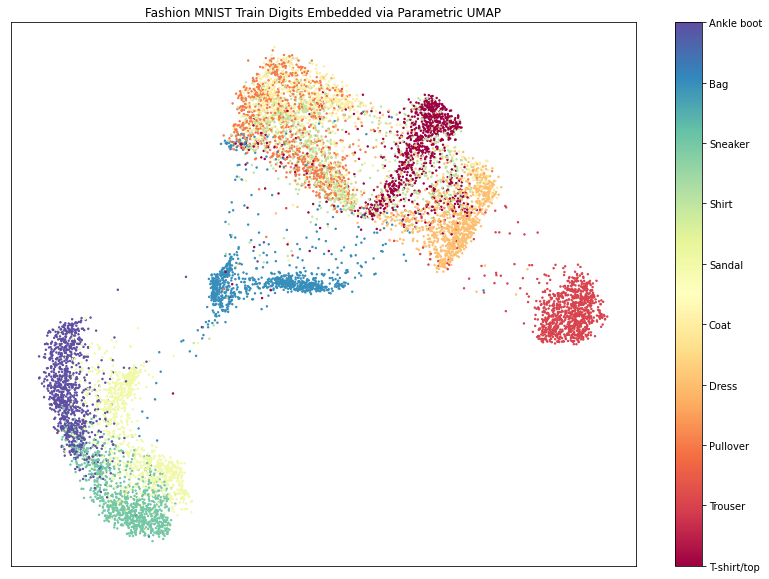

In [31]:
# running encoder is very expensive so let's take a subset of the data (expected run time is 3 hr on full train data)
subset_X_train = Scaled_X_train[np.random.choice(Scaled_X_train.shape[0], 10000, replace=False), :]

# running the encoder using parametric UMAP
embedder = umap.ParametricUMAP(encoder=encoder, dims=dims).fit(subset_X_train)
embedding_test_parametric = embedder.transform(Scaled_X_test.reshape(-1, 28, 28, 1))

# plotting the results
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding_test_parametric.T, s=2, c=np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via Parametric UMAP');

Overall, even though we still have separations in the regions we saw in the first plot, we still have poor 
separation between the classes for tops (shirts, pullovers, and coats). Moreover, the distances between the clusters seem to be smaller than in the unsupervised approach. 

The training time for this technique is also unideal. Training an encoder for 20 minutes didn't seem to add any meangingful value in separating the classes. It's possible that this lack of improvement is because we subsetted the data, but given the time constraints of this problem, applying the encoder to the full dataset would have been infeasible. 

We could try to use semi-supervised UMAP and pass in a subset of the labels. But choosing which points to label 
could be a time-consuming endeavor. 

Maybe instead of trying to brute force a model's understanding of these classes, we can build a model which queries 
for labels that it is most unsure about. Let's try to apply some active learning to our problem! 